# PLC siemens + realsense D455 rect depth matching

## Snap7 PLC connection

In [ ]:
#common variables
found_part_num=0

## PLC class import

In [8]:
import sys
sys.path.insert(1, '../python')
import plc

## PLC class debug

In [3]:
import snap7
import sys
import logging
from logging import handlers
from logging.handlers import RotatingFileHandler
import traceback
import time
import threading
from snap7.util import *
import yaml
import os
csd = '../python' #os.path.dirname(os.path.abspath(__file__))
config = yaml.safe_load(open(csd+"/config.yml"))

# TODO found_part_num
#found_part_num = 0
camera_db_num = config['plc']['camera_db_num']
reconnect_timeout = config['plc']['reconnect_timeout']

class PLC(threading.Thread):
    def __init__(self, plc_ip):
        #init
        threading.Thread.__init__(self, args=(), name=plc_ip, kwargs=None)
        self.plc_ip = plc_ip
        self.found_part_num = 0
        self.snapshotReq = False
        self.plc_ip = plc_ip
        self.logger = logging.getLogger("_plc_.client")
        #logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
        logging.basicConfig(level=config['logger']['level'],
                            handlers=[logging.StreamHandler(sys.stdout),
                                      logging.handlers.RotatingFileHandler(config['logger']['debug_file'],
                                                                           maxBytes=(1048576 * 5),
                                                                           backupCount=7)],
                            format=config['logger']['format'])
        self.snap7client = snap7.client.Client()
        self.connection_ok = False
        self.unreachable_time = 0
        self.connect_postpone = False

    def get_bool(self, db_number, offsetbyte, offsetbit):
        return snap7.util.get_bool(self.db_read(db_number, offsetbyte, 1), 0, offsetbit)

    def set_usint(self, db_number, offsetbyte, tag_value):
        tag_data = bytearray(1)
        snap7.util.set_usint(tag_data, 0, tag_value)
        self.snap7client.db_write(db_number, offsetbyte, tag_data)
        return True

    def db_read(self, db_number, offsetbyte, len_arr):
        return self.snap7client.db_read(db_number, offsetbyte, len_arr)

    def db_write(self, db_number, offsetbyte, tag_data):
        return self.snap7client.db_write(db_number, offsetbyte, tag_data)

    def run(self):
        self.logger.info(f"Connection with PLC {self.plc_ip} started")
        cur_thread = threading.current_thread()
        # Основной цикл
        while getattr(cur_thread, "do_run", True):
            try:
                time.sleep(1.2)
                if self.unreachable_time == 0 or (time.time() - self.unreachable_time) > reconnect_timeout:
                    if not self.snap7client.get_connected():
                        # Подключение к контроллеру ...
                        try:
                            self.connection_ok = False
                            self.logger.info(f"Подключение к контроллеру {self.plc_ip}...")
                            self.snap7client.connect(self.plc_ip, 0, 1)
                        except Exception as error:
                            self.logger.error(f"Не удалось подключиться к контроллеру: {self.plc_ip}\n"
                                              f"Ошибка {str(error)} {traceback.format_exc()}")
                            snap7.client.logger.disabled = True
                            self.unreachable_time = time.time()
                    else:
                        if not self.connection_ok:
                            self.connection_ok = True
                            self.unreachable_time = 0
                            self.logger.info(f"Соединение открыто {self.plc_ip}")
                            snap7.client.logger.disabled = False
                        try:
                            if not self.snapshotReq:
                                self.snapshotReq = self.get_bool(db_number=camera_db_num, offsetbyte=0, offsetbit=0)
                                if self.snapshotReq:
                                    self.logger.info(f"Строб съёмки пришёл {self.snapshotReq}")
                        except Exception as error:
                            self.logger.error(f"Не удалось считать строб съёмки: DB{camera_db_num}.DBX0.0\n"
                                              f"Ошибка {str(error)} {traceback.format_exc()}")
                            self.snap7client.disconnect()


                        if self.snapshotReq:
                            if self.found_part_num > 0:
                               self.logger.info(f"Запись результата распознования - номер найденной детали - {self.found_part_num}")
                               try:
                                   self.set_usint(db_number=camera_db_num, offsetbyte=1, tag_value=self.found_part_num)
                                   self.found_part_num = 0
                               except Exception as error:
                                   self.logger.error(f"Не удалось записать результат съёмки: DB{camera_db_num}.DBB1\n"
                                                     f"Ошибка {str(error)} {traceback.format_exc()}")
                                   self.snap7client.disconnect()
            except Exception as error:
                self.logger.error(f"Не удалось обработать цикл класса plc\n"
                                  f"Ошибка {str(error)} {traceback.format_exc()}")

In [3]:
my_plc = PLC('192.168.1.101')

In [4]:
my_plc.start()

## Part detection with Intel realsense D455 and OpenCV

In [ ]:
scaleAbs_alpha = 0.3
threshold = 0.65


In [1]:
#var huck
found_part_num = 0
teach_part_num = 0

#separate file - configurations of parts and settings
tolerance = 0.05
scaleAbs_alpha = 0.3
threshold = 0.65
#resolution_x,resolution_y=640,480
resolution_x,resolution_y=848,480
#resolution_x,resolution_y=1280,720
fps=5
parts=[ dict(code='8АТ-1250-11',part_name='Корпус маятника',step_name='Установ А',h=212,w=89,Zavg=400),
        dict(code='8АТ-1250-11',part_name='Корпус маятника',step_name='Установ B',h=208,w=87,Zavg=400),
        dict(code='8АТ-1250-11',part_name='Корпус маятника',step_name='Установ C',h=208,w=80.6,Zavg=400),
        dict(code='8АТ-1250-11',part_name='Корпус маятника',step_name='Установ D',h=208,w=80,Zavg=400),
        dict(code='8АТ-1250-11',part_name='Корпус маятника',step_name='Установ E',h=528,w=268,Zavg=400),
        dict(code='17115.2900.77',part_name='Переходник',step_name='Установ А',h=273,w=206,Zavg=400),
        dict(code='17115.2900.77',part_name='Переходник',step_name='Установ B',h=209.03,w=206,Zavg=400)]


import pyrealsense2 as rs
import numpy as np
import pyshine as ps
import socket
import cv2
import os

templateDir = 'templates'
lstdr = os.listdir(templateDir)
parts = [f for f in lstdr if os.path.isdir(templateDir+'/'+f)] 
templates = {str(p):[f for f in os.listdir(templateDir+'/'+p) if os.path.isfile(templateDir+'/'+p+'/'+f) and f.endswith('.png')] for p in parts} 

HTML=f"""
<html>
<body>
<center><img src="stream.mjpg" width='{resolution_x*2}' height='{resolution_y}' autoplay playsinline></center>
</body>
</html>
"""

StreamProps = ps.StreamProps
StreamProps.set_Page(StreamProps,HTML)
address = (socket.gethostbyname(socket.gethostname()),9001) # Enter your IP address 


class ImgCapture():

    def __init__(self):
        pass
    
    def read(self):

        # Wait for a coherent pair of frames: depth and color
        self.frames = pipeline.wait_for_frames()
        depth_frame = self.frames.get_depth_frame()
        color_frame = self.frames.get_color_frame()
        """
        # Convert images to numpy arrays
        #depth_image = np.asanyarray(depth_frame.get_data())
        frames = []
        for x in range(15):
            frameset = pipeline.wait_for_frames()
            frames.append(frameset.get_depth_frame())
        
        hole_filling = rs.hole_filling_filter()
        for x in range(15):
            frame = hole_filling.process(frames[x])
            frames[x] = np.asanyarray(frame.get_data())
        depth_image = np.min(frames, axis=0)        
        """
        hole_filling = rs.hole_filling_filter()
        depth_frame = hole_filling.process(depth_frame)
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        
        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=scaleAbs_alpha), cv2.COLORMAP_JET)
        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape
        
        #print (f"templates loop for {templates}")
        for part, pics in templates.items():
            #print (f"look for part {part}")
            for file in pics:
                #print (f"look for template {template}")
                template = cv2.imread(f"{templateDir}/{part}/{file}")
                h, w = template.shape[:2]
                methods = [cv2.TM_SQDIFF_NORMED, cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF_NORMED]
                res = cv2.matchTemplate(depth_colormap, template, methods[2])
                loc = np.where(res >= threshold)  # Coordinates y, x where the matching degree is greater than threshold
                #print("loc", loc)
                #for pt in zip(*loc[::-1]):  # * Indicates optional parameters
                if len(loc[0])>0:
                    print (f"Part {part} found" )
                    pt = list(zip(*loc[::-1]))[0]
                    right_bottom = (pt[0] + w, pt[1] + h)
                    cv2.rectangle(depth_colormap, pt, right_bottom, (0, 0, 255), 1)
                    continue
        
        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
        images = np.hstack((depth_colormap, color_image))
        
        if images is not None:
            ret = True
        return(ret, images)

    def isOpened(self):
        ret, _, _ = self.rs.get_frame_stream()
        return(ret)   
        

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
#depth_sensor = device.first_depth_sensor()
device_product_line = str(device.get_info(rs.camera_info.product_line))
print('device_product_line',device_product_line)

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)
align = rs.align(rs.stream.color)
config.enable_stream(rs.stream.depth, resolution_x, resolution_y, rs.format.z16, fps)
config.enable_stream(rs.stream.color, resolution_x, resolution_y, rs.format.bgr8, fps)

# Start streaming
pipeline.start(config)
try:
            StreamProps.set_Mode(StreamProps,'cv2')
            capImages = ImgCapture()
            StreamProps.set_Capture(StreamProps, capImages)
            StreamProps.set_Quality(StreamProps, 90)
            server = ps.Streamer(address, StreamProps)
            print('Server started at','http://'+address[0]+':'+str(address[1]))
            server.serve_forever()
            while True:
                cv2.waitKey(1)
        
finally: 
    # Stop streaming
    pipeline.stop() 

Warning! No module named 'sounddevice'
Warning! No module named 'matplotlib'
Warning! No module named 'keras'
device_product_line D400
Server started at http://172.17.0.2:9001


192.168.1.74 - - [26/Apr/2023 04:52:30] "GET /index.html HTTP/1.1" 200 -
192.168.1.74 - - [26/Apr/2023 04:52:31] "GET /stream.mjpg HTTP/1.1" 200 -
192.168.1.74 - - [26/Apr/2023 04:52:42] "GET /index.html HTTP/1.1" 200 -
192.168.1.74 - - [26/Apr/2023 04:52:42] "GET /stream.mjpg HTTP/1.1" 200 -


KeyboardInterrupt: 

In [ ]:
#cv2.destroyAllWindows()

In [298]:
import cv2 as cv
#import numpy as np

def template_demo():
    target = cv.imread("./templates/2/part4.png")
    tpl = cv.imread("./templates/2/part7.png")


    methods = [cv.TM_SQDIFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_CCOEFF_NORMED]  # Only test these three template matching methods

    for md in methods:
        #print(md)
        #correlation = cv2.matchTemplate(target, tpl, cv2.TM_CCORR_NORMED, mask=mask)
        #res = cv.matchTemplate(target, tpl, md, mask=mask)  # Get matching results
        # Match with template as both template and mask parameter
        res = cv.matchTemplate(target, tpl, md, None, tpl.copy())
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        if md == cv.TM_SQDIFF_NORMED:  # cv.TM_SQDIFF_NORMED is the most similar when it is the smallest, most similar when the others are the largest
            tl = min_loc
        else:
            tl = max_loc
        loc = np.where(res >= max_val)
        #cv.rectangle(target, tl, br, (0, 0, 255), 2)  # tl is the coordinates of the upper left corner, br is the coordinates of the lower right corner, so as to draw a rectangle
        #cv.imshow("match-"+str(md), target)
        print(md, min_val, max_val,tl)
template_demo()


1 0.10839670896530151 0.10839670896530151 (0, 0)
3 0.9469226002693176 0.9469226002693176 (0, 0)
5 0.2822503447532654 0.2822503447532654 (0, 0)


len(points_list) 1
Point: (7, 12)
Corresponding angle: 0
Corresponding scale: 100
Corresponding matched_thresh: 0.9923563003540039



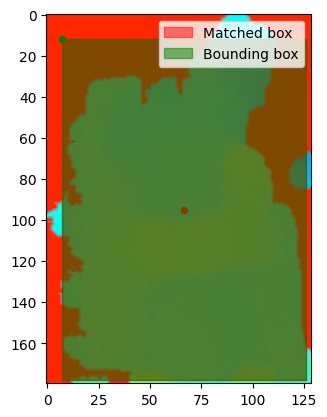

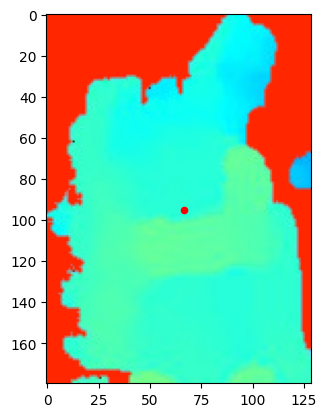

In [322]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

box_points = []
button_down = False

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def scale_image(image, percent, maxwh):
    color_scale_rate = 0
    max_width = maxwh[1]
    max_height = maxwh[0]
    max_percent_width = max_width / image.shape[1] * 100
    max_percent_height = max_height / image.shape[0] * 100
    max_percent = 0
    if max_percent_width < max_percent_height:
        max_percent = max_percent_width
    else:
        max_percent = max_percent_height
    if percent > max_percent:
        percent = max_percent
    width = int(image.shape[1] * percent / 100)
    height = int(image.shape[0] * percent / 100)
    image = image + int(percent * color_scale_rate)
    result = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    return result, percent

def invariantMatchTemplate(rgbimage, rgbtemplate, method, matched_thresh, rot_range, rot_interval, scale_range, scale_interval, rm_redundant):
    """
    rgbimage: RGB image where the search is running.
    rgbtemplate: RGB searched template. It must be not greater than the source image and have the same data type.
    method: [String] Parameter specifying the comparison method
    matched_thresh: [Float] Setting threshold of matched results(0~1).
    rgbdiff_thresh: [Float] Setting threshold of average RGB difference between template and source image.
    rot_range: [Integer] Array of range of rotation angle in degrees. Example: [0,360]
    rot_interval: [Integer] Interval of traversing the range of rotation angle in degrees.
    scale_range: [Integer] Array of range of scaling in percentage. Example: [50,200]
    scale_interval: [Integer] Interval of traversing the range of scaling in percentage.
    rm_redundant: [Boolean] Option for removing redundant matched results based on the width and height of the template.

    Returns: List of satisfied matched points in format [[point.x, point.y], angle, scale, matched_thresh].
    """
    image_maxwh = rgbimage.shape
    height, width, numchannel = rgbtemplate.shape
    all_points = []
    for next_angle in range(rot_range[0], rot_range[1], rot_interval):
        for next_scale in range(scale_range[0], scale_range[1], scale_interval):
            scaled_template, actual_scale = scale_image(rgbtemplate, next_scale, image_maxwh)
            if next_angle == 0:
                rotated_template = scaled_template
            else:
                rotated_template = rotate_image(scaled_template, next_angle)
            matched_points = cv2.matchTemplate(rgbimage, rotated_template, method, None, rotated_template.copy())
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matched_points)
            if method == cv2.TM_SQDIFF_NORMED:  # cv.TM_SQDIFF_NORMED is the most similar when it is the smallest, most similar when the others are the largest
                max_loc = min_loc
                max_val = 1 - max_val
            if max_val >= matched_thresh:
                all_points.append([max_loc, next_angle, actual_scale, max_val])
    all_points = sorted(all_points, key=lambda x: -x[3])
    if rm_redundant == True:
        lone_points_list = []
        visited_points_list = []
        for point_info in all_points:
            point = point_info[0]
            scale = point_info[2]
            all_visited_points_not_close = True
            if len(visited_points_list) != 0:
                for visited_point in visited_points_list:
                    if ((abs(visited_point[0] - point[0]) < (width * scale / 100)) and (abs(visited_point[1] - point[1]) < (height * scale / 100))):
                        all_visited_points_not_close = False
                if all_visited_points_not_close == True:
                    lone_points_list.append(point_info)
                    visited_points_list.append(point)
            else:
                lone_points_list.append(point_info)
                visited_points_list.append(point)
        points_list = lone_points_list
    else:
        points_list = all_points
    return points_list


def main():
    img_rgb = cv2.imread('./templates/2/part8.png')
    template_rgb = cv2.imread('./templates/2/part9.png')
    height, width = template_rgb.shape[0:2]
    points_list = invariantMatchTemplate(img_rgb, template_rgb, cv2.TM_CCORR_NORMED, 0.8, [-5,5], 1, [90,110], 2, True)
    fig, ax = plt.subplots(1)
    #plt.gcf().canvas.set_window_title('Template Matching Results')
    ax.imshow(img_rgb)
    centers_list = []
    print(f"len(points_list) {len(points_list)}")
    for point_info in points_list:
        point = point_info[0]
        print("Point:", point)
        angle = point_info[1]
        print("Corresponding angle:", angle)
        scale = point_info[2]
        print("Corresponding scale:", scale)
        matched_thresh = point_info[3]
        print("Corresponding matched_thresh:", matched_thresh)
        centers_list.append([point, scale])
        plt.scatter(point[0] + (width/2)*scale/100, point[1] + (height/2)*scale/100, s=20, color="red")
        plt.scatter(point[0], point[1], s=20, color="green")
        rectangle = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="red", alpha=0.50, label='Matched box')
        box = patches.Rectangle((point[0], point[1]), width*scale/100, height*scale/100, color="green", alpha=0.50, label='Bounding box')
        transform = mpl.transforms.Affine2D().rotate_deg_around(point[0] + width/2*scale/100, point[1] + height/2*scale/100, angle) + ax.transData
        rectangle.set_transform(transform)
        ax.add_patch(rectangle)
        ax.add_patch(box)
        plt.legend(handles=[rectangle,box])
        print()
    #plt.grid(True)
    plt.show()
    fig2, ax2 = plt.subplots(1)
    #plt.gcf().canvas.set_window_title('Template Matching Results')
    ax2.imshow(img_rgb)
    for point_info in centers_list:
        point = point_info[0]
        scale = point_info[1]
        plt.scatter(point[0]+width/2*scale/100, point[1]+height/2*scale/100, s=20, color="red")
    plt.show()


if __name__ == "__main__":
    main()

In [284]:

# USAGE
# python match.py --template cod_logo.png --images images

# import the necessary packages
import numpy as np
import argparse
import imutils
import glob
import cv2

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-t", "--template", required=True, help="Path to template image")
ap.add_argument("-i", "--images", required=True,
	help="Path to images where template will be matched")
ap.add_argument("-v", "--visualize",
	help="Flag indicating whether or not to visualize each iteration")
args = vars(ap.parse_args())

# load the image image, convert it to grayscale, and detect edges
template = cv2.imread(args["template"])
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(tH, tW) = template.shape[:2]
cv2.imshow("Template", template)

# loop over the images to find the template in
for imagePath in glob.glob(args["images"] + "/*.jpg"):
	# load the image, convert it to grayscale, and initialize the
	# bookkeeping variable to keep track of the matched region
	image = cv2.imread(imagePath)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	found = None

	# loop over the scales of the image
	for scale in np.linspace(0.2, 1.0, 20)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
		resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
		r = gray.shape[1] / float(resized.shape[1])

		# if the resized image is smaller than the template, then break
		# from the loop
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
		edged = cv2.Canny(resized, 50, 200)
		result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
		(_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

		# check to see if the iteration should be visualized
		if args.get("visualize", False):
			# draw a bounding box around the detected region
			clone = np.dstack([edged, edged, edged])
			cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
				(maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
			cv2.imshow("Visualize", clone)
			cv2.waitKey(0)

		# if we have found a new maximum correlation value, then ipdate
		# the bookkeeping variable
		if found is None or maxVal > found[0]:
			found = (maxVal, maxLoc, r)

	# unpack the bookkeeping varaible and compute the (x, y) coordinates
	# of the bounding box based on the resized ratio
	(_, maxLoc, r) = found
	(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
	(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

	# draw a bounding box around the detected result and display the image
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
	cv2.imshow("Image", image)
	cv2.waitKey(0)

ModuleNotFoundError: No module named 'imutils'

In [195]:
import cv2, os
import numpy as np


# Method: 0: SQDIFF | 1: SQDIFF NORMED | 2: TM CCORR | 3: TM CCORR NORMED | 4: TM COEFF | 5: TM COEFF NORMED
img_path = "./templates/2/part3.png"
tem_path = "./templates/2/part7.png"

def test():
    global img_path, tem_path

    def findImgthres(image_path, template_path, mask=False, method=1, thres=.95):
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_COLOR (cv2.IMREAD_UNCHANGED)
        tem = cv2.imread(tem_path, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_COLOR (cv2.IMREAD_UNCHANGED)
        # Match template with and without mask


        if mask and tem.shape[2] == 4:
            alpha_channel = np.array(cv2.split(tem)[3])
            cv2.imwrite("./mask.png", alpha_channel)
            result = cv2.matchTemplate(img, tem, method, mask=alpha_channel)
        else:
            #result = cv2.matchTemplate(img, tem, method)
            result = cv.matchTemplate(img, tem, method, None, tem)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
        # Nomrmalize result data to percent (0-1)
        #result = cv2.normalize(result, None, 0, 1, cv2.NORM_MINMAX, -1)

        # Invert Image to work similar across all methods!
        #if method == 0 or method == 1: result = (1 - result)

        result_list = np.where(result >= thres)

        return result, result_list, max_val, max_loc

    tmp_source = cv2.imread(img_path, cv2.IMREAD_COLOR)
    tmp_mask_source = cv2.imread(img_path, cv2.IMREAD_COLOR)
    tmp_tem = cv2.imread(tem_path, cv2.IMREAD_COLOR)
    result = findImgthres(img_path, tem_path, False, cv2.TM_CCORR_NORMED)
    mask_result = findImgthres(img_path, tem_path, True, cv2.TM_CCORR_NORMED)
    """
    # Mark original Image with mask
    matchLoc = mask_result[1]
    if matchLoc is not None:
        for loc in matchLoc:
            cv2.rectangle(tmp_mask_source, tuple(loc)[::-1], (loc[1] + tmp_tem.shape[1], loc[0] + tmp_tem.shape[0]), (0,0,0), 1)

    # Mark original Image without mask
    matchLoc = result[1]
    if matchLoc is not None:
        for loc in matchLoc:
            cv2.rectangle(tmp_source, tuple(loc)[::-1], (loc[1] + tmp_tem.shape[1], loc[0] + tmp_tem.shape[0]), (0,0,0), 1)
    """
    # Save Images
    _dir = os.path.dirname('./')
    cv2.imwrite(os.path.join(_dir, "source.png") , tmp_source)
    cv2.imwrite(os.path.join(_dir, "mask_source.png") , tmp_mask_source)
    cv2.imwrite(os.path.join(_dir, "result.png") , 255*result[0])
    cv2.imwrite(os.path.join(_dir, "mask_result.png") , 255*mask_result[0])

    # Output Result
    print(f"[NO MASK] {result[2]} Match Locs: {result[3]}")
    print(f"[MASK] {mask_result[2]} Match Locs: {mask_result[3]}")


if __name__ == "__main__":
    test()

[NO MASK] 0.96271812915802 Match Locs: (0, 0)
[MASK] 0.9623681306838989 Match Locs: (0, 0)


In [226]:
import cv2, os
import numpy as np

img_path = "./templates/2/part4.png"
tem_path = "./templates/2/part7.png"

def test():
    global img_path, tem_path

    def findImgthres(method, thres=.95):
        img = cv2.imread(img_path) # cv2.IMREAD_COLOR (cv2.IMREAD_UNCHANGED)
        tem = cv2.imread(tem_path) # cv2.IMREAD_COLOR (cv2.IMREAD_UNCHANGED)
        # Match template with and without mask

        result = cv.matchTemplate(img, tem, method, None, tem)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
        result_list = np.where(result >= thres)
        return result, result_list, max_val, max_loc

    mask_result = findImgthres(cv2.TM_CCORR_NORMED)

    print(f"[MASK] {mask_result[2]} Match Locs: {mask_result[3]}")


if __name__ == "__main__":
    test()


[MASK] 0.9469226002693176 Match Locs: (0, 0)


In [229]:
import cv2 as cv
#import numpy as np

def template_demo():
    target = cv.imread("./templates/2/part4.png")
    tpl = cv.imread("./templates/2/part7.png")

    res = cv.matchTemplate(target, tpl, cv.TM_CCORR_NORMED, None, tpl)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print(max_val,max_loc)
template_demo()


0.9469226002693176 (0, 0)
